라이브러리

In [1]:
# imports
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy
from tensorflow.keras.optimizers import Adam
import keras
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# 모델명(= 파일명) 설정
tank = 1
model_name = 'Test230715_tank1_nonlinear_crop'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [7]:
time_ranges = [('03:00:00', '05:59:00'), ('15:00:00', '17:59:00')]

japonica_training_data_feed = []
japonica_validation_data_feed = []

for time_range in time_ranges:
    start_time, end_time = time_range
    japonica_training_data_feed.append(japonica_training_data.between_time(start_time, end_time))
    japonica_validation_data_feed.append(japonica_validation_data.between_time(start_time, end_time))
    

japonica_training_data = pd.concat(japonica_training_data_feed)
japonica_validation_data = pd.concat(japonica_validation_data_feed)

In [8]:
japonica_training_features_X = japonica_training_data[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [9]:
japonica_training_features_X_chunks = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_y_chunks = np.asarray(japonica_training_features_y, dtype=np.float64)

japonica_validation_features_X_chunks = np.asarray(japonica_validation_features_X, dtype=np.float64)
japonica_validation_features_y_chunks = np.asarray(japonica_validation_features_y, dtype=np.float64)

In [10]:
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 16202 nVar: 8
nCar: 16202 nVar: 1
nCar: 16202 nVar: 8
nCar: 16202 nVar: 1


In [11]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-18]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[18:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-18]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[18:]

In [12]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 16184 nVar: 8
nCar: 16184 nVar: 1
nCar: 16184 nVar: 8
nCar: 16184 nVar: 1


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [13]:
# Create model
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=8))
model.add(Dense(32, activation="relu"))
model.add(Dense(8, activation="relu"))
# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.
model.add(Dense(1, activation="linear"))

# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Fit the model
history = model.fit(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop, validation_data=(japonica_validation_features_X_chunks_crop, japonica_validation_features_y_chunks_crop), epochs=10000000, batch_size=100, verbose=2, callbacks=[es])
model.save(model_name+'.h5')

2023-07-16 14:33:10.938310: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 14:33:11.494682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0
/home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2023-07-16 14:33:11.710997: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10000000


2023-07-16 14:33:13.103361: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


162/162 - 3s - loss: 16.1604 - val_loss: 1.7450
Epoch 2/10000000
162/162 - 1s - loss: 1.5996 - val_loss: 1.4291
Epoch 3/10000000
162/162 - 1s - loss: 1.3608 - val_loss: 1.3200
Epoch 4/10000000
162/162 - 1s - loss: 1.3252 - val_loss: 1.2563
Epoch 5/10000000
162/162 - 1s - loss: 1.3086 - val_loss: 1.2417
Epoch 6/10000000
162/162 - 1s - loss: 1.2883 - val_loss: 1.2946
Epoch 7/10000000
162/162 - 1s - loss: 1.3636 - val_loss: 1.3007
Epoch 8/10000000
162/162 - 1s - loss: 1.2808 - val_loss: 1.2271
Epoch 9/10000000
162/162 - 1s - loss: 1.2800 - val_loss: 1.3289
Epoch 10/10000000
162/162 - 1s - loss: 1.2947 - val_loss: 1.5815
Epoch 11/10000000
162/162 - 1s - loss: 1.2947 - val_loss: 1.2037
Epoch 12/10000000
162/162 - 1s - loss: 1.2536 - val_loss: 1.2236
Epoch 13/10000000
162/162 - 1s - loss: 1.2371 - val_loss: 1.1936
Epoch 14/10000000
162/162 - 1s - loss: 1.2838 - val_loss: 1.2550
Epoch 15/10000000
162/162 - 1s - loss: 1.4171 - val_loss: 1.3410
Epoch 16/10000000
162/162 - 1s - loss: 1.3126 - va

162/162 - 1s - loss: 0.9020 - val_loss: 1.1001
Epoch 128/10000000
162/162 - 1s - loss: 0.9308 - val_loss: 0.8476
Epoch 129/10000000
162/162 - 1s - loss: 0.9073 - val_loss: 0.8526
Epoch 130/10000000
162/162 - 1s - loss: 0.8991 - val_loss: 0.8568
Epoch 131/10000000
162/162 - 1s - loss: 0.9143 - val_loss: 1.2043
Epoch 132/10000000
162/162 - 1s - loss: 0.8909 - val_loss: 0.8460
Epoch 133/10000000
162/162 - 0s - loss: 0.8958 - val_loss: 0.8830
Epoch 134/10000000
162/162 - 1s - loss: 0.8915 - val_loss: 0.9702
Epoch 135/10000000
162/162 - 1s - loss: 0.9021 - val_loss: 0.8572
Epoch 136/10000000
162/162 - 1s - loss: 0.8741 - val_loss: 0.8580
Epoch 137/10000000
162/162 - 1s - loss: 0.8791 - val_loss: 0.9485
Epoch 138/10000000
162/162 - 1s - loss: 0.8942 - val_loss: 0.8582
Epoch 139/10000000
162/162 - 1s - loss: 0.8798 - val_loss: 0.9195
Epoch 140/10000000
162/162 - 1s - loss: 0.8663 - val_loss: 0.8342
Epoch 141/10000000
162/162 - 1s - loss: 0.8796 - val_loss: 0.8413
Epoch 142/10000000
162/162 - 

Epoch 252/10000000
162/162 - 1s - loss: 0.8133 - val_loss: 0.7872
Epoch 253/10000000
162/162 - 1s - loss: 0.7905 - val_loss: 0.7689
Epoch 254/10000000
162/162 - 1s - loss: 0.7759 - val_loss: 0.7638
Epoch 255/10000000
162/162 - 1s - loss: 0.7785 - val_loss: 0.7521
Epoch 256/10000000
162/162 - 1s - loss: 0.8167 - val_loss: 0.7905
Epoch 257/10000000
162/162 - 1s - loss: 0.7866 - val_loss: 0.7404
Epoch 258/10000000
162/162 - 1s - loss: 0.7761 - val_loss: 0.8271
Epoch 259/10000000
162/162 - 1s - loss: 0.8021 - val_loss: 0.7544
Epoch 260/10000000
162/162 - 1s - loss: 0.8136 - val_loss: 0.7943
Epoch 261/10000000
162/162 - 1s - loss: 0.7734 - val_loss: 0.7566
Epoch 262/10000000
162/162 - 1s - loss: 0.7811 - val_loss: 0.7554
Epoch 263/10000000
162/162 - 1s - loss: 0.7930 - val_loss: 0.8285
Epoch 264/10000000
162/162 - 1s - loss: 0.7923 - val_loss: 0.7673
Epoch 265/10000000
162/162 - 1s - loss: 0.7863 - val_loss: 0.7456
Epoch 266/10000000
162/162 - 1s - loss: 0.7952 - val_loss: 0.8957
Epoch 267/

162/162 - 1s - loss: 0.6838 - val_loss: 0.7993
Epoch 377/10000000
162/162 - 1s - loss: 0.7016 - val_loss: 0.7635
Epoch 378/10000000
162/162 - 1s - loss: 0.6741 - val_loss: 0.6439
Epoch 379/10000000
162/162 - 1s - loss: 0.6737 - val_loss: 0.6622
Epoch 380/10000000
162/162 - 1s - loss: 0.6710 - val_loss: 0.6276
Epoch 381/10000000
162/162 - 1s - loss: 0.6379 - val_loss: 0.6241
Epoch 382/10000000
162/162 - 1s - loss: 0.6428 - val_loss: 0.6205
Epoch 383/10000000
162/162 - 1s - loss: 0.6560 - val_loss: 0.6333
Epoch 384/10000000
162/162 - 1s - loss: 0.6416 - val_loss: 0.5979
Epoch 385/10000000
162/162 - 1s - loss: 0.6495 - val_loss: 0.6341
Epoch 386/10000000
162/162 - 1s - loss: 0.6636 - val_loss: 0.7133
Epoch 387/10000000
162/162 - 1s - loss: 0.6646 - val_loss: 0.7218
Epoch 388/10000000
162/162 - 1s - loss: 0.6652 - val_loss: 0.6222
Epoch 389/10000000
162/162 - 1s - loss: 0.6729 - val_loss: 0.6377
Epoch 390/10000000
162/162 - 1s - loss: 0.6528 - val_loss: 0.6546
Epoch 391/10000000
162/162 - 

Epoch 501/10000000
162/162 - 1s - loss: 0.5872 - val_loss: 0.6192
Epoch 502/10000000
162/162 - 1s - loss: 0.5816 - val_loss: 0.5605
Epoch 503/10000000
162/162 - 1s - loss: 0.5694 - val_loss: 0.5377
Epoch 504/10000000
162/162 - 1s - loss: 0.5891 - val_loss: 0.5604
Epoch 505/10000000
162/162 - 1s - loss: 0.5722 - val_loss: 0.5824
Epoch 506/10000000
162/162 - 1s - loss: 0.5743 - val_loss: 0.5947
Epoch 507/10000000
162/162 - 1s - loss: 0.5689 - val_loss: 0.5415
Epoch 508/10000000
162/162 - 1s - loss: 0.5669 - val_loss: 0.5588
Epoch 509/10000000
162/162 - 1s - loss: 0.5559 - val_loss: 0.5711
Epoch 510/10000000
162/162 - 1s - loss: 0.5760 - val_loss: 0.5689
Epoch 511/10000000
162/162 - 1s - loss: 0.5558 - val_loss: 0.5134
Epoch 512/10000000
162/162 - 1s - loss: 0.5827 - val_loss: 0.5895
Epoch 513/10000000
162/162 - 1s - loss: 0.5648 - val_loss: 0.5825
Epoch 514/10000000
162/162 - 1s - loss: 0.5669 - val_loss: 0.6106
Epoch 515/10000000
162/162 - 1s - loss: 0.5652 - val_loss: 0.5493
Epoch 516/

162/162 - 1s - loss: 0.5495 - val_loss: 0.5391
Epoch 626/10000000
162/162 - 1s - loss: 0.5387 - val_loss: 0.5286
Epoch 627/10000000
162/162 - 1s - loss: 0.5442 - val_loss: 0.5633
Epoch 628/10000000
162/162 - 1s - loss: 0.5429 - val_loss: 0.6705
Epoch 629/10000000
162/162 - 1s - loss: 0.5556 - val_loss: 0.5208
Epoch 630/10000000
162/162 - 1s - loss: 0.5285 - val_loss: 0.5217
Epoch 631/10000000
162/162 - 1s - loss: 0.5267 - val_loss: 0.5201
Epoch 632/10000000
162/162 - 1s - loss: 0.5361 - val_loss: 0.5029
Epoch 633/10000000
162/162 - 1s - loss: 0.5276 - val_loss: 0.5112
Epoch 634/10000000
162/162 - 1s - loss: 0.5444 - val_loss: 0.5186
Epoch 635/10000000
162/162 - 1s - loss: 0.5291 - val_loss: 0.5080
Epoch 636/10000000
162/162 - 1s - loss: 0.5470 - val_loss: 0.5334
Epoch 637/10000000
162/162 - 1s - loss: 0.5460 - val_loss: 0.5987
Epoch 638/10000000
162/162 - 1s - loss: 0.5542 - val_loss: 0.4925
Epoch 639/10000000
162/162 - 1s - loss: 0.5392 - val_loss: 0.5660
Epoch 640/10000000
162/162 - 

Epoch 750/10000000
162/162 - 1s - loss: 0.5153 - val_loss: 0.5496
Epoch 751/10000000
162/162 - 1s - loss: 0.5234 - val_loss: 0.5174
Epoch 752/10000000
162/162 - 1s - loss: 0.5551 - val_loss: 0.5866
Epoch 753/10000000
162/162 - 1s - loss: 0.5260 - val_loss: 0.5826
Epoch 754/10000000
162/162 - 1s - loss: 0.5273 - val_loss: 0.5690
Epoch 755/10000000
162/162 - 0s - loss: 0.5314 - val_loss: 0.4976
Epoch 756/10000000
162/162 - 0s - loss: 0.5042 - val_loss: 0.4951
Epoch 757/10000000
162/162 - 1s - loss: 0.5337 - val_loss: 0.5478
Epoch 758/10000000
162/162 - 1s - loss: 0.5558 - val_loss: 0.4856
Epoch 759/10000000
162/162 - 0s - loss: 0.5161 - val_loss: 0.5819
Epoch 760/10000000
162/162 - 1s - loss: 0.5414 - val_loss: 0.5579
Epoch 761/10000000
162/162 - 1s - loss: 0.5138 - val_loss: 0.4820
Epoch 762/10000000
162/162 - 1s - loss: 0.5328 - val_loss: 0.5365
Epoch 763/10000000
162/162 - 1s - loss: 0.5328 - val_loss: 0.5057
Epoch 764/10000000
162/162 - 1s - loss: 0.5263 - val_loss: 0.5065
Epoch 765/

162/162 - 1s - loss: 0.5105 - val_loss: 0.5115
Epoch 875/10000000
162/162 - 1s - loss: 0.5052 - val_loss: 0.5604
Epoch 876/10000000
162/162 - 1s - loss: 0.5061 - val_loss: 0.5702
Epoch 877/10000000
162/162 - 1s - loss: 0.5248 - val_loss: 0.5942
Epoch 878/10000000
162/162 - 1s - loss: 0.5756 - val_loss: 0.5478
Epoch 879/10000000
162/162 - 1s - loss: 0.5125 - val_loss: 0.5453
Epoch 880/10000000
162/162 - 1s - loss: 0.5123 - val_loss: 0.5067
Epoch 881/10000000
162/162 - 1s - loss: 0.5027 - val_loss: 0.4736
Epoch 882/10000000
162/162 - 1s - loss: 0.4874 - val_loss: 0.4887
Epoch 883/10000000
162/162 - 1s - loss: 0.5006 - val_loss: 0.4833
Epoch 884/10000000
162/162 - 1s - loss: 0.5113 - val_loss: 0.4880
Epoch 885/10000000
162/162 - 1s - loss: 0.4883 - val_loss: 0.4988
Epoch 886/10000000
162/162 - 1s - loss: 0.5060 - val_loss: 0.4934
Epoch 887/10000000
162/162 - 1s - loss: 0.4901 - val_loss: 0.4798
Epoch 888/10000000
162/162 - 1s - loss: 0.5081 - val_loss: 0.5515
Epoch 889/10000000
162/162 - 

Epoch 999/10000000
162/162 - 1s - loss: 0.5283 - val_loss: 0.5352
Epoch 1000/10000000
162/162 - 1s - loss: 0.4890 - val_loss: 0.4898
Epoch 1001/10000000
162/162 - 1s - loss: 0.5028 - val_loss: 0.4895
Epoch 1002/10000000
162/162 - 1s - loss: 0.4871 - val_loss: 0.5103
Epoch 1003/10000000
162/162 - 1s - loss: 0.4937 - val_loss: 0.4897
Epoch 1004/10000000
162/162 - 1s - loss: 0.5155 - val_loss: 0.4883
Epoch 1005/10000000
162/162 - 1s - loss: 0.4948 - val_loss: 0.4612
Epoch 1006/10000000
162/162 - 1s - loss: 0.5013 - val_loss: 0.4602
Epoch 1007/10000000
162/162 - 1s - loss: 0.5107 - val_loss: 0.5564
Epoch 1008/10000000
162/162 - 1s - loss: 0.4909 - val_loss: 0.5023
Epoch 1009/10000000
162/162 - 1s - loss: 0.4919 - val_loss: 0.5761
Epoch 1010/10000000
162/162 - 1s - loss: 0.5208 - val_loss: 0.5663
Epoch 1011/10000000
162/162 - 1s - loss: 0.5114 - val_loss: 0.4549
Epoch 1012/10000000
162/162 - 1s - loss: 0.5070 - val_loss: 0.5013
Epoch 1013/10000000
162/162 - 1s - loss: 0.4970 - val_loss: 0.4

162/162 - 1s - loss: 0.4825 - val_loss: 0.4754
Epoch 1122/10000000
162/162 - 1s - loss: 0.5238 - val_loss: 0.5247
Epoch 1123/10000000
162/162 - 1s - loss: 0.4920 - val_loss: 0.4544
Epoch 1124/10000000
162/162 - 1s - loss: 0.4850 - val_loss: 0.4658
Epoch 1125/10000000
162/162 - 1s - loss: 0.4897 - val_loss: 0.5124
Epoch 1126/10000000
162/162 - 1s - loss: 0.4860 - val_loss: 0.5260
Epoch 1127/10000000
162/162 - 1s - loss: 0.4880 - val_loss: 0.5111
Epoch 1128/10000000
162/162 - 1s - loss: 0.4910 - val_loss: 0.4716
Epoch 1129/10000000
162/162 - 1s - loss: 0.4797 - val_loss: 0.4733
Epoch 1130/10000000
162/162 - 1s - loss: 0.4847 - val_loss: 0.4713
Epoch 1131/10000000
162/162 - 1s - loss: 0.4846 - val_loss: 0.4938
Epoch 1132/10000000
162/162 - 1s - loss: 0.4939 - val_loss: 0.4757
Epoch 1133/10000000
162/162 - 1s - loss: 0.5069 - val_loss: 0.4762
Epoch 1134/10000000
162/162 - 1s - loss: 0.4824 - val_loss: 0.4786
Epoch 1135/10000000
162/162 - 1s - loss: 0.4863 - val_loss: 0.4912
Epoch 1136/1000

Epoch 1244/10000000
162/162 - 1s - loss: 0.4735 - val_loss: 0.4927
Epoch 1245/10000000
162/162 - 1s - loss: 0.4679 - val_loss: 0.4635
Epoch 1246/10000000
162/162 - 1s - loss: 0.4875 - val_loss: 0.4587
Epoch 1247/10000000
162/162 - 1s - loss: 0.5087 - val_loss: 0.4700
Epoch 1248/10000000
162/162 - 1s - loss: 0.4838 - val_loss: 0.4754
Epoch 1249/10000000
162/162 - 1s - loss: 0.4787 - val_loss: 0.4777
Epoch 1250/10000000
162/162 - 1s - loss: 0.4791 - val_loss: 0.4871
Epoch 1251/10000000
162/162 - 1s - loss: 0.4660 - val_loss: 0.4922
Epoch 1252/10000000
162/162 - 1s - loss: 0.4762 - val_loss: 0.4709
Epoch 1253/10000000
162/162 - 1s - loss: 0.4671 - val_loss: 0.4611
Epoch 1254/10000000
162/162 - 1s - loss: 0.4921 - val_loss: 0.5086
Epoch 1255/10000000
162/162 - 1s - loss: 0.5012 - val_loss: 0.4805
Epoch 1256/10000000
162/162 - 1s - loss: 0.4715 - val_loss: 0.4498
Epoch 1257/10000000
162/162 - 1s - loss: 0.4786 - val_loss: 0.4451
Epoch 1258/10000000
162/162 - 1s - loss: 0.4725 - val_loss: 0.

162/162 - 1s - loss: 0.4823 - val_loss: 0.4607
Epoch 1367/10000000
162/162 - 1s - loss: 0.4707 - val_loss: 0.4684
Epoch 1368/10000000
162/162 - 1s - loss: 0.4644 - val_loss: 0.4464
Epoch 1369/10000000
162/162 - 1s - loss: 0.4545 - val_loss: 0.4526
Epoch 1370/10000000
162/162 - 1s - loss: 0.4711 - val_loss: 0.4501
Epoch 1371/10000000
162/162 - 1s - loss: 0.4537 - val_loss: 0.4518
Epoch 1372/10000000
162/162 - 1s - loss: 0.4668 - val_loss: 0.4545
Epoch 1373/10000000
162/162 - 1s - loss: 0.4597 - val_loss: 0.4340
Epoch 1374/10000000
162/162 - 1s - loss: 0.4583 - val_loss: 0.4524
Epoch 1375/10000000
162/162 - 1s - loss: 0.4706 - val_loss: 0.4573
Epoch 1376/10000000
162/162 - 1s - loss: 0.4723 - val_loss: 0.4573
Epoch 1377/10000000
162/162 - 1s - loss: 0.4696 - val_loss: 0.4769
Epoch 1378/10000000
162/162 - 1s - loss: 0.4593 - val_loss: 0.4456
Epoch 1379/10000000
162/162 - 1s - loss: 0.4632 - val_loss: 0.4361
Epoch 1380/10000000
162/162 - 1s - loss: 0.4639 - val_loss: 0.5039
Epoch 1381/1000

Epoch 1489/10000000
162/162 - 1s - loss: 0.4535 - val_loss: 0.4241
Epoch 1490/10000000
162/162 - 1s - loss: 0.4584 - val_loss: 0.4396
Epoch 1491/10000000
162/162 - 1s - loss: 0.4544 - val_loss: 0.4469
Epoch 1492/10000000
162/162 - 1s - loss: 0.4717 - val_loss: 0.5027
Epoch 1493/10000000
162/162 - 1s - loss: 0.4709 - val_loss: 0.4512
Epoch 1494/10000000
162/162 - 1s - loss: 0.4392 - val_loss: 0.4374
Epoch 1495/10000000
162/162 - 1s - loss: 0.4897 - val_loss: 0.4565
Epoch 1496/10000000
162/162 - 1s - loss: 0.4435 - val_loss: 0.4743
Epoch 1497/10000000
162/162 - 1s - loss: 0.4620 - val_loss: 0.4340
Epoch 1498/10000000
162/162 - 1s - loss: 0.4520 - val_loss: 0.4475
Epoch 1499/10000000
162/162 - 1s - loss: 0.4583 - val_loss: 0.4338
Epoch 1500/10000000
162/162 - 1s - loss: 0.4590 - val_loss: 0.4932
Epoch 1501/10000000
162/162 - 1s - loss: 0.4511 - val_loss: 0.4303
Epoch 1502/10000000
162/162 - 1s - loss: 0.4669 - val_loss: 0.4869
Epoch 1503/10000000
162/162 - 1s - loss: 0.4537 - val_loss: 0.

162/162 - 1s - loss: 0.4407 - val_loss: 0.4157
Epoch 1612/10000000
162/162 - 1s - loss: 0.4595 - val_loss: 0.4217
Epoch 1613/10000000
162/162 - 1s - loss: 0.4672 - val_loss: 0.4256
Epoch 1614/10000000
162/162 - 1s - loss: 0.4557 - val_loss: 0.4301
Epoch 1615/10000000
162/162 - 1s - loss: 0.4581 - val_loss: 0.4153
Epoch 1616/10000000
162/162 - 1s - loss: 0.4386 - val_loss: 0.4418
Epoch 1617/10000000
162/162 - 1s - loss: 0.4553 - val_loss: 0.4221
Epoch 1618/10000000
162/162 - 1s - loss: 0.4334 - val_loss: 0.4393
Epoch 1619/10000000
162/162 - 1s - loss: 0.4735 - val_loss: 0.4707
Epoch 1620/10000000
162/162 - 1s - loss: 0.4411 - val_loss: 0.5319
Epoch 1621/10000000
162/162 - 1s - loss: 0.4786 - val_loss: 0.4510
Epoch 1622/10000000
162/162 - 1s - loss: 0.4606 - val_loss: 0.4466
Epoch 1623/10000000
162/162 - 1s - loss: 0.4684 - val_loss: 0.4433
Epoch 1624/10000000
162/162 - 1s - loss: 0.4462 - val_loss: 0.4507
Epoch 1625/10000000
162/162 - 1s - loss: 0.4434 - val_loss: 0.4406
Epoch 1626/1000

Epoch 1734/10000000
162/162 - 1s - loss: 0.4261 - val_loss: 0.4161
Epoch 1735/10000000
162/162 - 1s - loss: 0.4522 - val_loss: 0.4207
Epoch 1736/10000000
162/162 - 1s - loss: 0.4442 - val_loss: 0.4106
Epoch 1737/10000000
162/162 - 1s - loss: 0.4621 - val_loss: 0.4733
Epoch 1738/10000000
162/162 - 1s - loss: 0.4421 - val_loss: 0.4198
Epoch 1739/10000000
162/162 - 1s - loss: 0.4362 - val_loss: 0.4309
Epoch 1740/10000000
162/162 - 1s - loss: 0.4551 - val_loss: 0.4140
Epoch 1741/10000000
162/162 - 1s - loss: 0.4295 - val_loss: 0.4338
Epoch 1742/10000000
162/162 - 1s - loss: 0.4675 - val_loss: 0.4648
Epoch 1743/10000000
162/162 - 1s - loss: 0.4328 - val_loss: 0.5052
Epoch 1744/10000000
162/162 - 1s - loss: 0.4549 - val_loss: 0.4053
Epoch 1745/10000000
162/162 - 1s - loss: 0.4351 - val_loss: 0.4655
Epoch 1746/10000000
162/162 - 1s - loss: 0.4495 - val_loss: 0.5494
Epoch 1747/10000000
162/162 - 1s - loss: 0.4489 - val_loss: 0.4137
Epoch 1748/10000000
162/162 - 1s - loss: 0.4377 - val_loss: 0.

162/162 - 1s - loss: 0.4484 - val_loss: 0.4391
Epoch 1857/10000000
162/162 - 1s - loss: 0.4668 - val_loss: 0.4096
Epoch 1858/10000000
162/162 - 1s - loss: 0.4258 - val_loss: 0.5290
Epoch 1859/10000000
162/162 - 1s - loss: 0.4310 - val_loss: 0.4643
Epoch 1860/10000000
162/162 - 1s - loss: 0.4608 - val_loss: 0.4639
Epoch 1861/10000000
162/162 - 1s - loss: 0.4306 - val_loss: 0.4776
Epoch 1862/10000000
162/162 - 1s - loss: 0.4424 - val_loss: 0.4658
Epoch 1863/10000000
162/162 - 1s - loss: 0.4647 - val_loss: 0.4677
Epoch 1864/10000000
162/162 - 1s - loss: 0.4413 - val_loss: 0.4159
Epoch 1865/10000000
162/162 - 1s - loss: 0.4233 - val_loss: 0.4177
Epoch 1866/10000000
162/162 - 1s - loss: 0.4362 - val_loss: 0.5178
Epoch 1867/10000000
162/162 - 1s - loss: 0.4329 - val_loss: 0.4967
Epoch 1868/10000000
162/162 - 1s - loss: 0.4304 - val_loss: 0.4453
Epoch 1869/10000000
162/162 - 1s - loss: 0.4182 - val_loss: 0.4022
Epoch 1870/10000000
162/162 - 1s - loss: 0.4316 - val_loss: 0.4137
Epoch 1871/1000

Epoch 1979/10000000
162/162 - 1s - loss: 0.4361 - val_loss: 0.4176
Epoch 1980/10000000
162/162 - 1s - loss: 0.4259 - val_loss: 0.4271
Epoch 1981/10000000
162/162 - 1s - loss: 0.4431 - val_loss: 0.4135
Epoch 1982/10000000
162/162 - 1s - loss: 0.4193 - val_loss: 0.4059
Epoch 1983/10000000
162/162 - 1s - loss: 0.4252 - val_loss: 0.4065
Epoch 1984/10000000
162/162 - 1s - loss: 0.4173 - val_loss: 0.4330
Epoch 1985/10000000
162/162 - 1s - loss: 0.4218 - val_loss: 0.4018
Epoch 1986/10000000
162/162 - 1s - loss: 0.4371 - val_loss: 0.4756
Epoch 1987/10000000
162/162 - 1s - loss: 0.4330 - val_loss: 0.4376
Epoch 1988/10000000
162/162 - 1s - loss: 0.4373 - val_loss: 0.4130
Epoch 1989/10000000
162/162 - 1s - loss: 0.4280 - val_loss: 0.4024
Epoch 1990/10000000
162/162 - 1s - loss: 0.4222 - val_loss: 0.3980
Epoch 1991/10000000
162/162 - 1s - loss: 0.4258 - val_loss: 0.4103
Epoch 1992/10000000
162/162 - 1s - loss: 0.4171 - val_loss: 0.3941
Epoch 1993/10000000
162/162 - 1s - loss: 0.4121 - val_loss: 0.

162/162 - 1s - loss: 0.4165 - val_loss: 0.4437
Epoch 2102/10000000
162/162 - 1s - loss: 0.4289 - val_loss: 0.4157
Epoch 2103/10000000
162/162 - 1s - loss: 0.4313 - val_loss: 0.4434
Epoch 2104/10000000
162/162 - 1s - loss: 0.4166 - val_loss: 0.4286
Epoch 2105/10000000
162/162 - 1s - loss: 0.4196 - val_loss: 0.4295
Epoch 2106/10000000
162/162 - 1s - loss: 0.4380 - val_loss: 0.4425
Epoch 2107/10000000
162/162 - 1s - loss: 0.4295 - val_loss: 0.4708
Epoch 2108/10000000
162/162 - 1s - loss: 0.4230 - val_loss: 0.4455
Epoch 2109/10000000
162/162 - 1s - loss: 0.4127 - val_loss: 0.4294
Epoch 2110/10000000
162/162 - 1s - loss: 0.4105 - val_loss: 0.3953
Epoch 2111/10000000
162/162 - 1s - loss: 0.4159 - val_loss: 0.3967
Epoch 2112/10000000
162/162 - 1s - loss: 0.4839 - val_loss: 0.4824
Epoch 2113/10000000
162/162 - 1s - loss: 0.4252 - val_loss: 0.4103
Epoch 2114/10000000
162/162 - 1s - loss: 0.4589 - val_loss: 0.4000
Epoch 2115/10000000
162/162 - 1s - loss: 0.4259 - val_loss: 0.4135
Epoch 2116/1000

Epoch 2224/10000000
162/162 - 1s - loss: 0.4084 - val_loss: 0.3830
Epoch 2225/10000000
162/162 - 1s - loss: 0.4081 - val_loss: 0.4153
Epoch 2226/10000000
162/162 - 1s - loss: 0.4187 - val_loss: 0.4436
Epoch 2227/10000000
162/162 - 1s - loss: 0.4282 - val_loss: 0.4380
Epoch 2228/10000000
162/162 - 1s - loss: 0.4295 - val_loss: 0.4504
Epoch 2229/10000000
162/162 - 1s - loss: 0.4524 - val_loss: 0.4455
Epoch 2230/10000000
162/162 - 1s - loss: 0.4192 - val_loss: 0.4081
Epoch 2231/10000000
162/162 - 1s - loss: 0.4047 - val_loss: 0.4092
Epoch 2232/10000000
162/162 - 1s - loss: 0.4050 - val_loss: 0.3822
Epoch 2233/10000000
162/162 - 1s - loss: 0.4146 - val_loss: 0.3912
Epoch 2234/10000000
162/162 - 1s - loss: 0.4154 - val_loss: 0.3826
Epoch 2235/10000000
162/162 - 1s - loss: 0.4230 - val_loss: 0.4665
Epoch 2236/10000000
162/162 - 1s - loss: 0.4118 - val_loss: 0.4179
Epoch 2237/10000000
162/162 - 1s - loss: 0.4254 - val_loss: 0.4114
Epoch 2238/10000000
162/162 - 1s - loss: 0.4168 - val_loss: 0.

162/162 - 1s - loss: 0.4660 - val_loss: 0.4598
Epoch 2347/10000000
162/162 - 1s - loss: 0.4596 - val_loss: 0.4967
Epoch 2348/10000000
162/162 - 1s - loss: 0.4631 - val_loss: 0.4823
Epoch 2349/10000000
162/162 - 1s - loss: 0.4582 - val_loss: 0.4723
Epoch 2350/10000000
162/162 - 1s - loss: 0.4606 - val_loss: 0.4501
Epoch 2351/10000000
162/162 - 1s - loss: 0.4700 - val_loss: 0.5095
Epoch 2352/10000000
162/162 - 1s - loss: 0.4603 - val_loss: 0.4874
Epoch 2353/10000000
162/162 - 1s - loss: 0.4616 - val_loss: 0.4402
Epoch 2354/10000000
162/162 - 1s - loss: 0.4709 - val_loss: 0.4857
Epoch 2355/10000000
162/162 - 1s - loss: 0.4786 - val_loss: 0.4465
Epoch 2356/10000000
162/162 - 1s - loss: 0.4690 - val_loss: 0.4505
Epoch 2357/10000000
162/162 - 1s - loss: 0.4617 - val_loss: 0.4640
Epoch 2358/10000000
162/162 - 1s - loss: 0.4597 - val_loss: 0.5100
Epoch 2359/10000000
162/162 - 1s - loss: 0.4659 - val_loss: 0.4488
Epoch 2360/10000000
162/162 - 1s - loss: 0.4645 - val_loss: 0.4590
Epoch 2361/1000

모델 평가

In [14]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [15]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[-0.01064701  0.40971872 -0.12234397 ... -0.24879962  0.02704097
   0.10911962]
 [-0.06829152 -1.4144242   0.7893506  ... -1.9814819  -0.19405334
  -0.2545708 ]
 [-0.03124087 -0.07185581 -0.06047019 ...  0.1115803  -0.14382377
  -0.00931055]
 ...
 [-0.03634796 -1.1308912   0.07525359 ... -0.06581309  0.16880606
  -0.38520858]
 [ 0.16788082 -0.0308745   0.8003089  ...  0.03019073  0.12313838
   0.02639264]
 [-0.11164326  0.03562637  1.0406625  ... -0.01803013  0.16774671
  -0.05052442]]


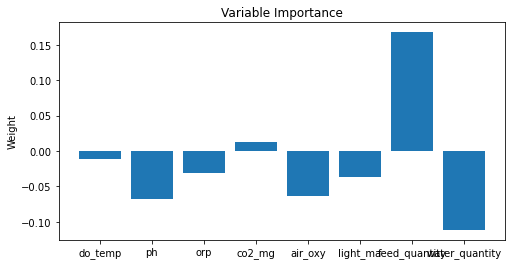

In [19]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(8), weights[:, 0])
ax.set_xticks(range(8))
ax.set_xticklabels(['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [20]:
japonica_validation_features_X

,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
mea_dt,,,,,,,,
2021-07-21 03:00:00,30.2,5.27,213.6,11.9,0.0,4.0,0.0,0.0
2021-07-21 03:01:00,30.2,5.27,213.3,11.9,0.0,3.9,0.0,0.0
2021-07-21 03:02:00,30.2,5.27,213.4,11.9,0.0,4.1,0.0,0.0
2021-07-21 03:03:00,30.2,5.27,213.4,11.9,0.0,4.0,0.0,0.0
2021-07-21 03:04:00,30.2,5.27,213.5,11.8,0.0,3.9,0.0,0.0
...,...,...,...,...,...,...,...,...
2021-09-08 17:55:00,28.9,5.42,156.1,32.1,0.0,3.9,0.0,0.0
2021-09-08 17:56:00,28.9,5.42,156.2,31.9,0.0,4.0,0.0,0.0
2021-09-08 17:57:00,28.9,5.42,156.2,31.9,0.0,4.0,0.0,0.0


In [21]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 16202 nVar: 8


/tmp/ipykernel_2943575/1737833184.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']


In [24]:
y_date = japonica_validation_features_y.loc['2021-07-21 00:00':'2021-09-10 20:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 16202 nVar: 1
nCar: 16202 nVar: 1


/tmp/ipykernel_2943575/1228628032.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  y_date = japonica_validation_features_y.loc['2021-07-21 00:00':'2021-09-10 20:59']


16202


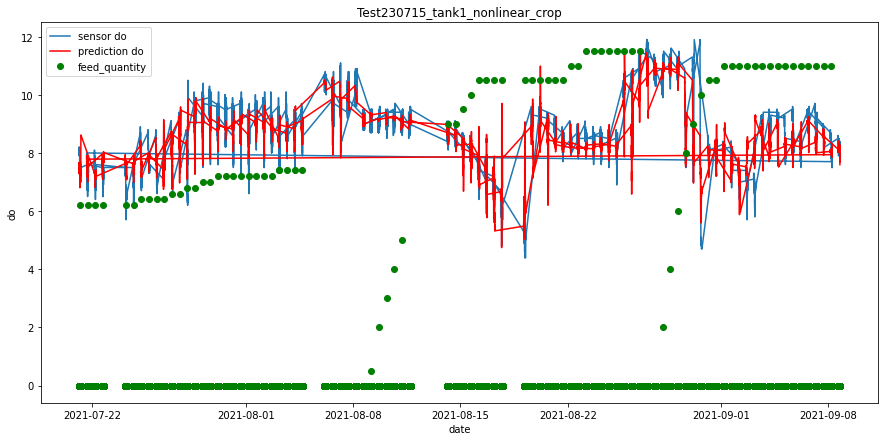

507/507 [==============================] - 2s 3ms/step - loss: 0.4879
MSE // MAE // R-squared  0.4879284203052521


In [26]:
grapeNEva(model,X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [28]:
X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-09-08 23:59']
X_test = X[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 8


In [29]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1
nCar: 64800 nVar: 1


64800


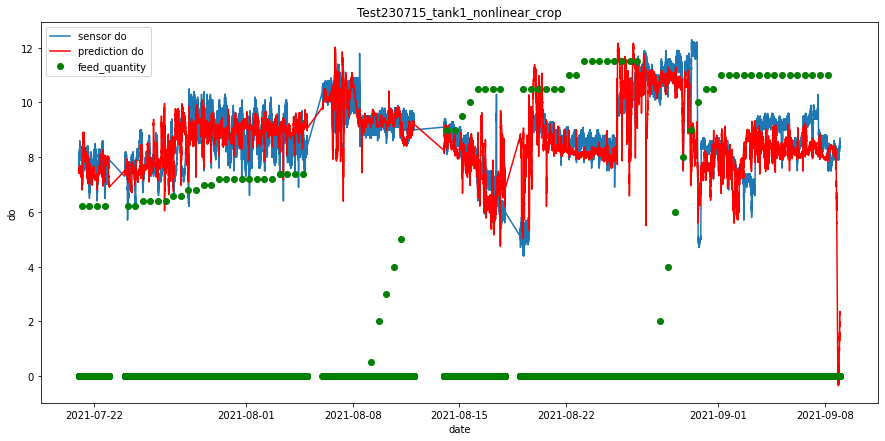

2025/2025 [==============================] - 6s 3ms/step - loss: 1.0118
MSE // MAE // R-squared  1.01176917552948


In [30]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [31]:
X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-07-31 23:59']
X_test = X[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14400 nVar: 8


In [32]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14400 nVar: 1
nCar: 14400 nVar: 1


14400


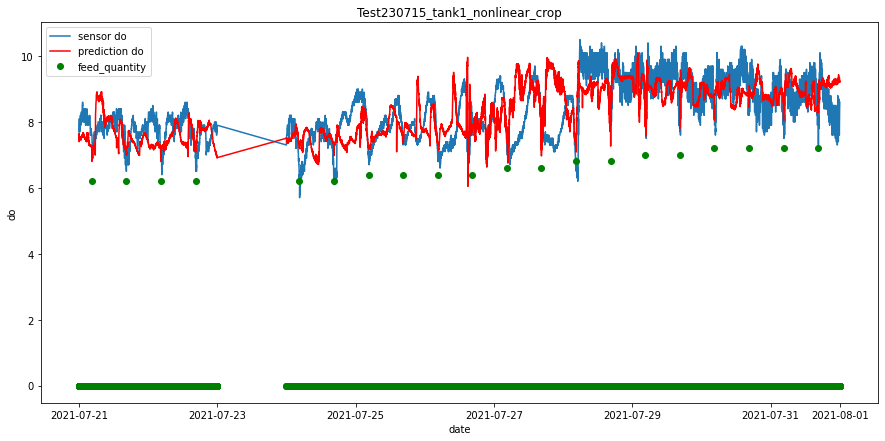

450/450 [==============================] - 1s 3ms/step - loss: 0.5729
MSE // MAE // R-squared  0.572922945022583


In [33]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [34]:
X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-07-21 23:59']
X_test = X[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 8
nCar: 1440 nVar: 8


In [35]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 1
nCar: 1440 nVar: 1


1440


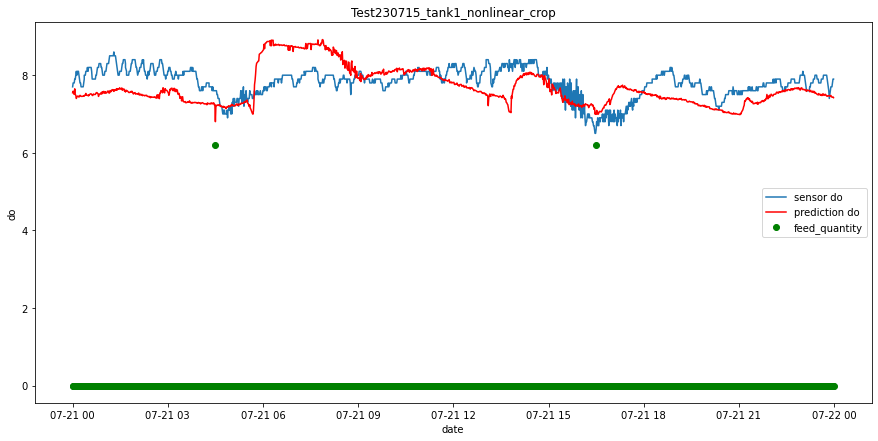

45/45 [==============================] - 0s 2ms/step - loss: 0.2659
MSE // MAE // R-squared  0.2658618688583374


In [36]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [37]:
X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-07-21 11:59']
X_test = X[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 8


In [38]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 720 nVar: 1


720


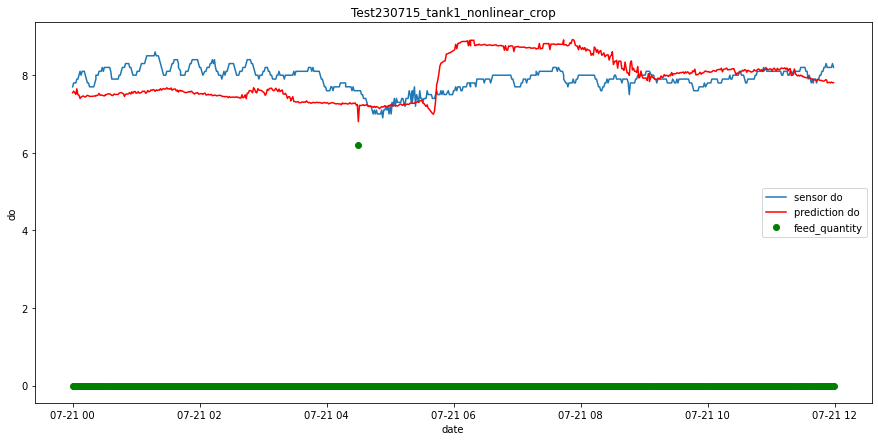

23/23 [==============================] - 0s 1ms/step - loss: 0.3341
MSE // MAE // R-squared  0.33413195610046387


In [39]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [40]:
japonica_validation_features.at['2021-07-21 08:00', 'feed_quantity'] = 6

X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-07-21 11:59']
X_test = X[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 8


In [41]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 720 nVar: 1


720


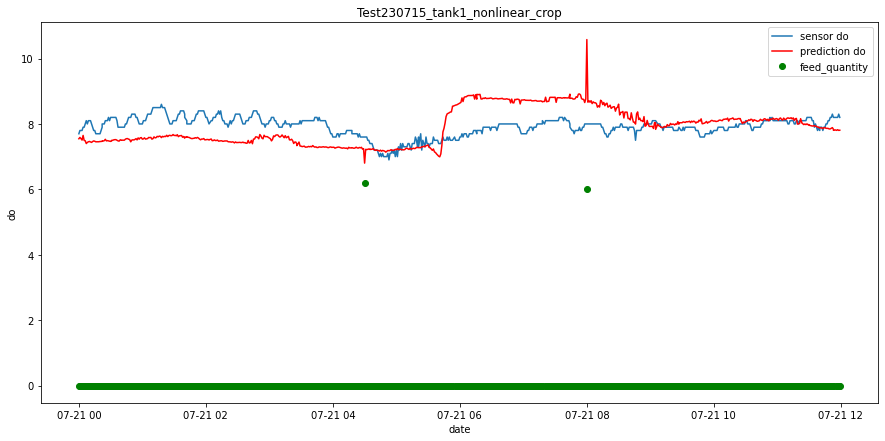

23/23 [==============================] - 0s 2ms/step - loss: 0.3427
MSE // MAE // R-squared  0.34267938137054443


In [42]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)